# SpatioTemporal Asset Catalog

All the layers produced by Geo-harmonizer project are publicly available in [SpatioTemporal Asset Catalog](https://stacspec.org) (STAC - [http://stac.opendatascience.eu](http://stac.opendatascience.eu)) as [Cloud-Optimized GeoTIFF (COG)](https://cogeo.org). The STAC specification provides a common language to describe a range of geospatial information, making them more easily indexed and discoverable on the internet.

In this tutorial, we will show how our current STAC implementation was **populated**, and how you can **search** for specific layers, **visualizing** and **downloading** them to local folder considering region of interest (``bounding box``).

First, let’s import the necessary modules

In [1]:
import sys
sys.path.insert(0, '../../')

import json
import pystac
import whoosh
import matplotlib.pyplot as plt

import rasterio
from pyproj import Transformer
from rasterio.windows import Window, from_bounds

from eumap.misc import GoogleSheet
from eumap.datasets.eo import STACGenerator, STACIndex
from eumap.plotter import plot_stac_collection, plot_rasters
from eumap.raster import read_rasters, save_rasters

from pathlib import Path

## Populating the catalog

We implemented a static catalog, according to the STAC specification, hosting the output files in a ``S3 bucket`` accessible through ``HTTP``. All the STAC files were automatically produced considering a set of metadata fields predefined and accessible through [Google Spreadsheet](https://docs.google.com/spreadsheets/d/10tAhEpZ7TYPD0UWhrI0LHcuIzGZNt5AgSjx2Bu-FciU). which were be filled by multiple users in parallel and programmatically accessed by eumap.

We used ``eumap.misc.GoogleSheet`` to access a specific Google spreadsheet URL converting it in a set of [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [2]:
key_file = '/mnt/apollo/stac/gaia-319808-913d36b5fca4.json'
url = 'https://docs.google.com/spreadsheets/d/10tAhEpZ7TYPD0UWhrI0LHcuIzGZNt5AgSjx2Bu-FciU'

gsheet = GoogleSheet(key_file, url, verbose=True)

[22:33:39] Accessing https://docs.google.com/spreadsheets/d/10tAhEpZ7TYPD0UWhrI0LHcuIzGZNt5AgSjx2Bu-FciU
[22:33:40] Retrieving the data from catalogs
[22:33:41]  Parsing column id
[22:33:41]  Parsing column title
[22:33:41]  Parsing column description
[22:33:41] Retrieving the data from collections
[22:33:41]  Parsing column id
[22:33:41]  Parsing column catalog
[22:33:41]  Parsing column title
[22:33:41]  Parsing column description
[22:33:41]  Parsing column keywords_list
[22:33:41]  Parsing column version
[22:33:41]  Parsing column doi
[22:33:41]  Parsing column layer_unit
[22:33:41]  Parsing column contact_name
[22:33:41]  Parsing column contact_email
[22:33:41]  Parsing column providers_list
[22:33:41]  Parsing column license
[22:33:41]  Parsing column platform
[22:33:41]  Parsing column instruments_list
[22:33:41]  Parsing column gsd
[22:33:41]  Parsing column start_date
[22:33:41]  Parsing column end_date
[22:33:41]  Parsing column date_step
[22:33:41]  Parsing column date_unit
[

Let's check a few columns of the ``collections`` sheet:

In [4]:
gsheet.collections[['id','title','start_date','end_date','url_1']]

,id,title,start_date,end_date,url_1
0,lcv_blue_landsat.glad.ard,Quarterly blue band of GLAD landsat ARD (2000–...,2000-01-01,2020-12-01,https://s3.eu-central-1.wasabisys.com/eumap/lc...
1,lcv_green_landsat.glad.ard,Quarterly green band of GLAD landsat ARD (2000...,2000-01-01,2020-12-01,https://s3.eu-central-1.wasabisys.com/eumap/lc...
2,lcv_nir_landsat.glad.ard,Quarterly NIR band of GLAD landsat ARD (2000–2...,2000-01-01,2020-12-01,https://s3.eu-central-1.wasabisys.com/eumap/lc...
3,lcv_red_landsat.glad.ard,Quarterly red band of GLAD landsat ARD (2000–2...,2000-01-01,2020-12-01,https://s3.eu-central-1.wasabisys.com/eumap/lc...
4,lcv_swir1_landsat.glad.ard,Quarterly SWIR1 band of GLAD landsat ARD (2000...,2000-01-01,2020-12-01,https://s3.eu-central-1.wasabisys.com/eumap/lc...
...,...,...,...,...,...
129,sol_db.od_eumap,Soil bulk density (2000–2020),2000-01-01,2020-12-31,https://s3.eu-central-1.wasabisys.com/eumap/so...
130,sol_log.oc_eumap,Soil log organic carbon content (2000–2020),2000-01-01,2020-12-31,https://s3.eu-central-1.wasabisys.com/eumap/so...
131,sol_ph.h2o_eumap,Soil pH in H2O (2000–2020),2000-01-01,2020-12-31,https://s3.eu-central-1.wasabisys.com/eumap/so...
132,sol_sand.tot.psa_eumap,Soil sand content (2000–2020),2000-01-01,2020-12-31,https://s3.eu-central-1.wasabisys.com/eumap/so...


In the production environment we did populate all the layers defined in the ``collections`` sheet, a process that toke a few hours. 

For a demonstration purpose, in this tutorial we will populate only two collections:

In [5]:
row_filter = gsheet.collections['id'].str.contains('fagus.sylvatica')
gsheet.collections = gsheet.collections[row_filter]
gsheet.collections[['id','title','start_date','end_date','url_1']]

,id,title,start_date,end_date,url_1
54,veg_fagus.sylvatica_anv.eml,ANV - Probability distribution for Fagus Sylva...,2000-01-01,2020-12-31,https://s3.eu-central-1.wasabisys.com/eumap/ve...
70,veg_fagus.sylvatica_pnv.eml,PNV - Probability distribution for Fagus sylva...,2018-01-01,2020-12-31,https://s3.eu-central-1.wasabisys.com/eumap/ve...


We used ``eumap.datasets.eo.STACGenerator``, based on [pystac](https://pystac.readthedocs.io/en/stable/), to parse all the metadata fields, generate the [collections, items and asset](https://github.com/radiantearth/stac-spec), including COG URLs and thumbnails:

In [6]:
stac_generator = STACGenerator(gsheet, verbose=True)

thumb_base_url=f'https://s3.eu-central-1.wasabisys.com/stac'
stac_generator.save_all(output_dir='stac_demo', thumb_base_url=thumb_base_url)

[22:33:47] Accesing COG bounds (https://s3.eu-central-1.wasabisys.com/eumap/veg/veg_fagus.sylvatica_anv.eml_p_30m_0..0cm_2000..2002_eumap_epsg3035_v0.2.tif)
[22:33:47] Accesing COG bounds (https://s3.eu-central-1.wasabisys.com/eumap/veg/veg_fagus.sylvatica_anv.eml_p_30m_0..0cm_2002..2006_eumap_epsg3035_v0.2.tif)
[22:33:47] Accesing COG bounds (https://s3.eu-central-1.wasabisys.com/eumap/veg/veg_fagus.sylvatica_anv.eml_p_30m_0..0cm_2006..2010_eumap_epsg3035_v0.2.tif)
[22:33:47] Accesing COG bounds (https://s3.eu-central-1.wasabisys.com/eumap/veg/veg_fagus.sylvatica_anv.eml_p_30m_0..0cm_2010..2014_eumap_epsg3035_v0.2.tif)
[22:33:47] Accesing COG bounds (https://s3.eu-central-1.wasabisys.com/eumap/veg/veg_fagus.sylvatica_anv.eml_p_30m_0..0cm_2014..2018_eumap_epsg3035_v0.2.tif)
[22:33:47] Accesing COG bounds (https://s3.eu-central-1.wasabisys.com/eumap/veg/veg_fagus.sylvatica_anv.eml_p_30m_0..0cm_2018..2020_eumap_epsg3035_v0.2.tif)
[22:33:47] Accesing COG bounds (https://s3.eu-central-1.wa

The STAC files were produced in ``./stac_demo``, including the ``catalog.json``

In [16]:
catalog_fn = './stac_demo/odse/catalog.json'
print(json.dumps(json.load(open(catalog_fn)), sort_keys=True, indent=4))

{
    "description": "Spatio-Temporal Asset Catalog for European-wide layers provided by [Open Data Science Europe](http://opendatascience.eu).",
    "id": "odse",
    "links": [
        {
            "href": "./catalog.json",
            "rel": "root",
            "title": "OpenDataScience Europe",
            "type": "application/json"
        },
        {
            "href": "./veg_fagus.sylvatica_anv.eml/collection.json",
            "rel": "child",
            "title": "ANV - Probability distribution for Fagus Sylvatica (2000\u20132020)",
            "type": "application/json"
        },
        {
            "href": "./veg_fagus.sylvatica_pnv.eml/collection.json",
            "rel": "child",
            "title": "PNV - Probability distribution for Fagus sylvatica (2000\u20132020)",
            "type": "application/json"
        }
    ],
    "stac_extensions": [],
    "stac_version": "1.0.0",
    "title": "OpenDataScience Europe",
    "type": "Catalog"
}


...and PNG thumbnails:

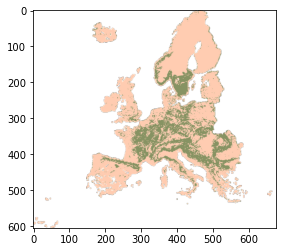

In [14]:
thumb_fn = './stac_demo/odse/veg_fagus.sylvatica_anv.eml/veg_fagus.sylvatica_anv.eml_2018.01.01..2020.12.31/veg_fagus.sylvatica_anv.eml_p_30m_0..0cm_2018..2020_eumap_epsg3035_v0.2.png'
img = plt.imread(thumb_fn)
plt.imshow(img)
plt.show()

## Accessing the catalog

We recommend also [pystac](https://pystac.readthedocs.io/en/stable/) to access our catalog:

In [2]:
STAC_URL = 'https://s3.eu-central-1.wasabisys.com/stac/odse/catalog.json'
catalog = pystac.Catalog.from_file(STAC_URL)

Considering that the current implementation is a static catalog, without the [search endpoint](https://github.com/radiantearth/stac-api-spec/blob/master/item-search/README.md), we developed local STAC index, based on [whoosh](https://whoosh.readthedocs.io/en/latest/searching.html), to allow the users search for specific layers. The ``eumap.datasets.eo.STACIndex`` class can be used to provide similar functionality for any other static catalog compatible with STAC. 

In [3]:
index = STACIndex(catalog, verbose=True)

[22:52:00] Retriving all collections from OpenDataScience Europe
[22:52:20] Creating index for 184 collections


By default the local index is created in ``./stac_index`` and after that you can execute **full-text searches**:

In [4]:
result = index.search('Soil*')
print(json.dumps(result, sort_keys=True, indent=4))

[
    {
        "id": "sol_clay.tot.psa_eumap",
        "pos": 0,
        "title": "Soil clay content (2000\u20132020)"
    },
    {
        "id": "sol_db.od_eumap",
        "pos": 1,
        "title": "Soil bulk density (2000\u20132020)"
    },
    {
        "id": "sol_ph.h2o_eumap",
        "pos": 2,
        "title": "Soil pH in H2O (2000\u20132020)"
    },
    {
        "id": "sol_sand.tot.psa_eumap",
        "pos": 3,
        "title": "Soil sand content (2000\u20132020)"
    },
    {
        "id": "sol_log.oc_eumap",
        "pos": 4,
        "title": "Soil log organic carbon content (2000\u20132020)"
    }
]


Let' use the search result to retrieve a **collection** by id and get its first **item**:

In [7]:
collection_id = result[4]['id']
collection_first_item = next(catalog.get_child(collection_id).get_all_items())
collection_first_item

<Item id=sol_log.oc_eumap_2000.01.01..2003.12.31>

For the returned item, let's access all its assets. 

You can access the same item in [STAC-Browser](https://stac.opendatascience.eu/sol_log.oc_eumap/sol_log.oc_eumap_2000.01.01..2003.12.31/sol_log.oc_eumap_2000.01.01..2003.12.31.json) to cross-check the result:

In [6]:
 for key, item in collection_first_item.get_assets().items():
    print(f'- {key}:\n  {item}')

- log.oc_m_s0..0cm:
  <Asset href=https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2000_eumap_epsg3035_v0.2.tif>
- log.oc_m_s30..30cm:
  <Asset href=https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s30..30cm_2000_eumap_epsg3035_v0.2.tif>
- log.oc_m_s60..60cm:
  <Asset href=https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s60..60cm_2000_eumap_epsg3035_v0.2.tif>
- log.oc_m_s100..100cm:
  <Asset href=https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s100..100cm_2000_eumap_epsg3035_v0.2.tif>
- log.oc_md_s0..0cm:
  <Asset href=https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_md_30m_s0..0cm_2000_eumap_epsg3035_v0.2.tif>
- log.oc_md_s30..30cm:
  <Asset href=https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_md_30m_s30..30cm_2000_eumap_epsg3035_v0.2.tif>
- log.oc_md_s60..60cm:
  <Asset href=https://s3.eu-central

Let's visualize all the thumbnails for the main asset:

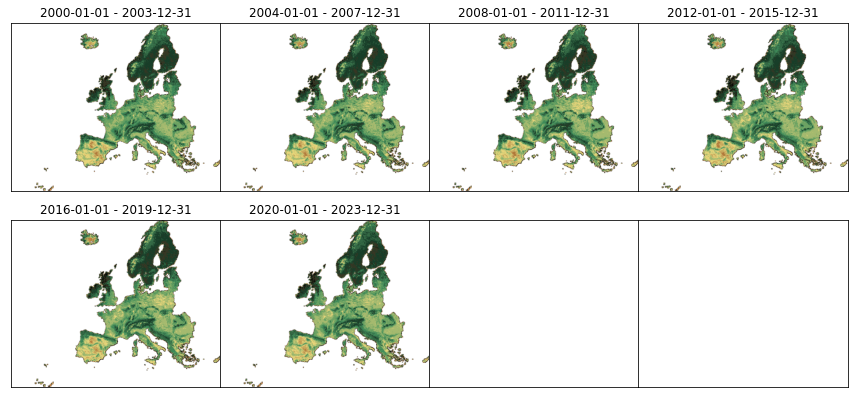

In [7]:
 plot_stac_collection(catalog.get_child(collection_id))

It's also possible visualize thumbnails for a different asset informing the ``thumb_id``:

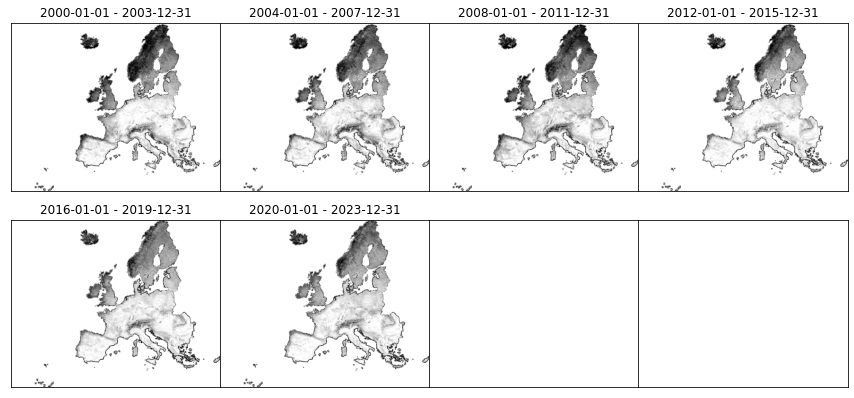

In [8]:
 plot_stac_collection(catalog.get_child(collection_id), thumb_id='log.oc_md_s60..60cm_preview')

### Data access and download 

Now, we can retrieve all COG URLs for a specific asset (``href`` property), what will allow us to read the actual raster data, as Numpy array, and later save it as local GeoTIFF files.  

In [8]:
def cog_urls(collection, asset_id):
    return [ item.assets[asset_id].href for item in collection.get_all_items() ]

collection_urls = cog_urls(catalog.get_child(collection_id), 'log.oc_m_s0..0cm')
print(json.dumps(collection_urls, sort_keys=True, indent=4))

[
    "https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2000_eumap_epsg3035_v0.2.tif",
    "https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2004_eumap_epsg3035_v0.2.tif",
    "https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2008_eumap_epsg3035_v0.2.tif",
    "https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2012_eumap_epsg3035_v0.2.tif",
    "https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2016_eumap_epsg3035_v0.2.tif",
    "https://s3.eu-central-1.wasabisys.com/eumap/sol/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2020_eumap_epsg3035_v0.2.tif"
]


As example, let's use the bounding box of [Wageningen / NL](https://goo.gl/maps/rPD85H2LqQ2fHqQTA). 

For a more interactively example, based on ipyleaflet, access [ODSE Workshop 2021 - Training Sessions](https://gitlab.com/geoharmonizer_inea/odse-workshop-2021/-/blob/main/Python-training/07_working_with_cog_in_python.ipynb).

In [11]:
bounds = (5.437546, 51.920556, 5.772629, 52.063468)

Let's transform the bounding box to ETRS89/LAEA projection system before we can define a [window](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html) to read the COG files:

In [12]:
base_raster = rasterio.open(collection_urls[0])

transformer = Transformer.from_crs("epsg:4326", base_raster.crs, always_xy=True)
left, bottom = transformer.transform(bounds[0], bounds[1])
right, top = transformer.transform(bounds[2], bounds[3])

window = from_bounds(left, bottom, right, top, base_raster.transform)
print(f'left={left}, bottom={bottom}, right={right}, top={top}\n')
print(f'window = {window}')

left=4007342.4750108747, bottom=3210978.832030329, right=4031270.870186194, top=3225468.6391858133

window = Window(col_off=103578.08250036248, row_off=74484.71202713957, width=797.6131725106388, height=482.99357184948167)


Using this window we can quickly read directly from a large COG file stored in our ODSE STAC.

[23:14:42] Reading 6 raster files using 4 workers


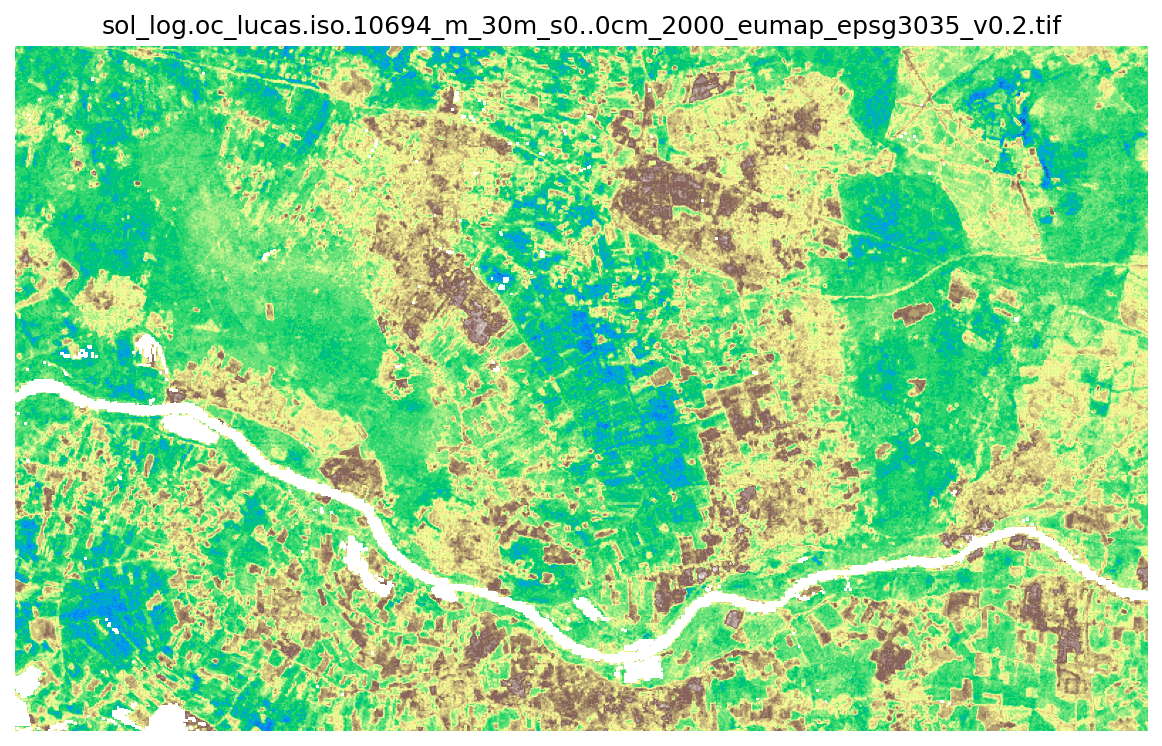

In [13]:
cog_url = collection_urls[0]

data, _ = read_rasters(raster_files=collection_urls, spatial_win=window, verbose=True)
plot_rasters(data[:,:,0].astype('float32'), cmaps="terrain_r", nodata=base_raster.nodata, titles=[ Path(cog_url).name ])

Using ``eumap.raster.save_rasters`` we can save the clipped data by passing the COG as the reference file along with the window definition.

In [14]:
roi_label = 'Wageningen'
workdir = Path('stac_download')

fn_rasters = [ workdir.joinpath(collection_id).joinpath(roi_label).joinpath(Path(url).name) for url in collection_urls ]
fn_rasters = save_rasters(fn_base_raster=collection_urls[0], fn_raster_list=fn_rasters, data=data, spatial_win=window, verbose=True)

print(json.dumps([str(f) for f in fn_rasters], sort_keys=True, indent=4))

[23:14:49] Writing 6 raster files using 4 workers
[
    "stac_download/sol_log.oc_eumap/Wageningen/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2000_eumap_epsg3035_v0.2.tif",
    "stac_download/sol_log.oc_eumap/Wageningen/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2004_eumap_epsg3035_v0.2.tif",
    "stac_download/sol_log.oc_eumap/Wageningen/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2008_eumap_epsg3035_v0.2.tif",
    "stac_download/sol_log.oc_eumap/Wageningen/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2012_eumap_epsg3035_v0.2.tif",
    "stac_download/sol_log.oc_eumap/Wageningen/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2016_eumap_epsg3035_v0.2.tif",
    "stac_download/sol_log.oc_eumap/Wageningen/sol_log.oc_lucas.iso.10694_m_30m_s0..0cm_2020_eumap_epsg3035_v0.2.tif"
]
